---

# <b> 창원 AI 아카데미: 데이터 분석 해커톤

* 일시: 2023년 7월 10일 ~ 12일
* 참가자: 백종환 </b>

<br>

---

---
# <b> * 문제 * </b>

### <b> *2012년부터 2021년까지의 창원시 표준지공시지가를 이용하여 2022년 창원시 표준지공시지가를 예측하시오.* </b>
---

## <b> 1. 데이터 전처리 </b>

> 필요 **라이브러리** 호출

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.offline import iplot, init_notebook_mode

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

import warnings
warnings.filterwarnings(action='ignore')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

### 파일 불러오기
> 다수의 csv 파일에서 필요한 부분만 추출해서 하나로 합침.

In [2]:
df_list = []
for i in range(2012, 2022):
    if i == 2016:
        df = pd.read_csv("2016년 표준지 공시지가.csv", encoding='cp949')
        # df = pd.read_csv('/users/jjong/desktop/vscode/CWNU_ICT/창원AI아카데미(데이터분석 해커톤)/2016년 표준지 공시지가.csv', encoding='cp949')
        df['시도명'] = df['시도']
        df['시군구명'] = df['시군구.1']
        df['소재지'] = df['동리']
        df['지리적위치2'] = df['지리적위치']
        df['형상명'] = df['형상']
        df['지세명'] = df['지세']
        df['용도지역1'] = df['용도지역']
        df = df.drop(['시도', '시군구.1', '동리', '지리적위치', '형상', '지세', '용도지역', '읍면', '본번지.1', '부번지.1', '지번구분.1','부번지'], axis=1)
        df['연도'] = pd.to_datetime(i, format='%Y').year
        df_list.append(df)
    else:
        try:
            df = pd.read_csv(f"{i}년 표준지 공시지가.csv", encoding='cp949')
            # df = pd.read_csv(f'/users/jjong/desktop/vscode/CWNU_ICT/창원AI아카데미(데이터분석 해커톤)/{i}년 표준지 공시지가.csv', encoding='cp949')
            df['연도'] = pd.to_datetime(i, format='%Y').year
            df_list.append(df)
        except UnicodeDecodeError:
            df = pd.read_csv(f"{i}년 표준지 공시지가.csv", encoding='utf-8')
            # df = pd.read_csv(f'/users/jjong/desktop/vscode/CWNU_ICT/창원AI아카데미(데이터분석 해커톤)/{i}년 표준지 공시지가.csv', encoding='utf-8')
            df['연도'] = pd.to_datetime(i, format='%Y').year
            df_list.append(df)

data = pd.concat(df_list, ignore_index=True)

In [3]:
# y2022 = pd.read_csv(f'/users/jjong/desktop/vscode/CWNU_ICT/창원AI아카데미(데이터분석 해커톤)/2022년 표준지 공시지가.csv', encoding='utf-8')
y2022 = pd.read_csv("2022년 표준지 공시지가.csv", encoding='utf-8')

y2022['연도'] = pd.to_datetime(2022, format='%Y').year
y2022['연도'] = pd.to_datetime(y2022['연도'], format='%Y')
y2022

,일련번호,시군구,읍면동리,지번구분,본번지,부번지,시도명,시군구명,소재지,지목,...,이용상황,주위환경,지세명,형상명,도로교통,공시지가,지리적위치1,지리적위치2,방위,연도
0,1,11110,10100,1,0003,52,서울특별시,종로구,청운동 3-52,공원,...,공원등,시가지주변 야산지대,급경사지,부정형,세로(불),493500,경기상고,북측 인근,NaN,2022-01-01
1,2,11110,10100,1,0004,2,서울특별시,종로구,청운동 4-2,임야,...,자연림,시가지주변 야산지대,완경사지,부정형,맹지,730500,경가상고,북서측 근거리,남향,2022-01-01
2,3,11110,10100,1,0004,15,서울특별시,종로구,청운동 4-15,대,...,단독주택,기존 주택지대,완경사지,사다리형,세로(가),4250000,경기상고,북서측 인근,북동향,2022-01-01
3,4,11110,10100,1,0008,9,서울특별시,종로구,청운동 8-9,대,...,연립주택,일반 주택지대,급경사지,부정형,세로(가),3930000,청운중학교,서측인근,남향,2022-01-01
4,5,11110,10100,1,0008,15,서울특별시,종로구,청운동 8-15,대,...,연립주택,기존 주택지대,급경사지,사다리형,세로(가),3855000,경기상고,서측인근,남서향,2022-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540045,4367,50130,32026,1,1582,0,제주특별자치도,서귀포시,표선면 토산리 1582,전,...,과수원,지방도주변 농경지대,평지,사다리형,맹지,18500,토산1리노인복지회관,북측 원거리,NaN,2022-01-01
540046,4368,50130,32026,1,1629,1,제주특별자치도,서귀포시,표선면 토산리 1629-1,전,...,전,순수 농경지대,평지,사다리형,소로한면,61000,소소름,남동측 인근,NaN,2022-01-01
540047,4369,50130,32026,1,1766,1,제주특별자치도,서귀포시,표선면 토산리 1766-1,과수원,...,과수원,지방도주변 농경지대,완경사지,부정형,세로(가),49500,토산1리사무소,북서측 인근,NaN,2022-01-01
540048,4370,50130,32026,1,1876,0,제주특별자치도,서귀포시,표선면 토산리 1876,과수원,...,과수원,지방도주변 농경지대,완경사지,부정형,중로한면,89000,토산1리사무소,남서측 인근,NaN,2022-01-01


In [4]:
original = data.iloc[:, 6:].copy()
original = original.drop(['용도지역2', '지리적위치1', '지리적위치2', '방위', '소재지'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020000 entries, 0 to 5019999
Data columns (total 23 columns):
 #   Column  Dtype  
---  ------  -----  
 0   일련번호    int64  
 1   시군구     int64  
 2   읍면동리    int64  
 3   지번구분    int64  
 4   본번지     object 
 5   부번지     object 
 6   시도명     object 
 7   시군구명    object 
 8   소재지     object 
 9   지목      object 
 10  면적      float64
 11  용도지역1   object 
 12  용도지역2   object 
 13  이용상황    object 
 14  주위환경    object 
 15  지세명     object 
 16  형상명     object 
 17  도로교통    object 
 18  공시지가    int64  
 19  지리적위치1  object 
 20  지리적위치2  object 
 21  방위      object 
 22  연도      int64  
dtypes: float64(1), int64(6), object(16)
memory usage: 880.9+ MB


In [5]:
filtered_data = data[(data['시도명'].str.contains('경상남도'))]
filtered_data = filtered_data[filtered_data['시군구명'].str.contains('창원')]
filtered_data

,일련번호,시군구,읍면동리,지번구분,본번지,부번지,시도명,시군구명,소재지,지목,...,이용상황,주위환경,지세명,형상명,도로교통,공시지가,지리적위치1,지리적위치2,방위,연도
431093,1,48121,10100,1,0006,0000,경상남도,창원의창구,북동 6,대,...,단독주택,기존 주택지대,완경사지,사다리형,세각(불),410000,북동공설시장,북동측인근,남향,2012
431094,2,48121,10100,1,0028,0000,경상남도,창원의창구,북동 28,대,...,다세대,기존 주택지대,평지,사다리형,소로한면,540000,창원향교,남서측인근,북향,2012
431095,3,48121,10100,1,0072,0000,경상남도,창원의창구,북동 72,대,...,단독주택,기존 주택지대,평지,부정형,세로(불),450000,북동공설시장,동측인근,북서향,2012
431096,4,48121,10100,1,0090,0002,경상남도,창원의창구,북동 90-2,대,...,단독주택,기존 주택지대,평지,부정형,소로한면,555000,북동공설시장,동측인근,남향,2012
431097,5,48121,10100,1,0100,0002,경상남도,창원의창구,북동 100-2,대,...,단독주택,기존 주택지대,평지,부정형,소로한면,590000,북동공설시장,동측인근,남향,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4955755,1315,48129,16500,1,0839,0,경상남도,창원진해구,가주동 839,체육용지,...,골프장_회원제,순수 야산지대,완경사지,부정형,소로한면,67500,용원컨트리클럽,내,NaN,2021
4955756,1316,48129,16500,2,0008,0,경상남도,창원진해구,가주동 산8,임야,...,자연림,순수 산림지대,급경사지,부정형,맹지,3000,주포마을,북서측 근거리,남동향,2021
4955757,1317,48129,16500,2,0017,0,경상남도,창원진해구,가주동 산17,임야,...,자연림,순수 산림지대,완경사지,부정형,맹지,27500,주포마을,북측 인근,남동향,2021
4955758,1318,48129,16500,2,0070,0,경상남도,창원진해구,가주동 산70,임야,...,자연림,마을주변 야산지대,완경사지,부정형,세로(불),23000,주포마을,서측 근거리,남동향,2021


> <u>**결측치**</u> 확인 및 <u>**NaN**</u>이 다수 포함된 불필요한 열 삭제

In [6]:
df = filtered_data.iloc[:, 6:].copy()
df = df.drop(['용도지역2', '지리적위치1', '지리적위치2', '방위'], axis=1)
df['가격'] = df['면적'] * df['공시지가']
df

,시도명,시군구명,소재지,지목,면적,용도지역1,이용상황,주위환경,지세명,형상명,도로교통,공시지가,연도,가격
431093,경상남도,창원의창구,북동 6,대,159.0,제1종일반주거지역,단독주택,기존 주택지대,완경사지,사다리형,세각(불),410000,2012,65190000.0
431094,경상남도,창원의창구,북동 28,대,182.0,제1종일반주거지역,다세대,기존 주택지대,평지,사다리형,소로한면,540000,2012,98280000.0
431095,경상남도,창원의창구,북동 72,대,162.0,제1종일반주거지역,단독주택,기존 주택지대,평지,부정형,세로(불),450000,2012,72900000.0
431096,경상남도,창원의창구,북동 90-2,대,147.0,제1종일반주거지역,단독주택,기존 주택지대,평지,부정형,소로한면,555000,2012,81585000.0
431097,경상남도,창원의창구,북동 100-2,대,180.0,제1종일반주거지역,단독주택,기존 주택지대,평지,부정형,소로한면,590000,2012,106200000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4955755,경상남도,창원진해구,가주동 839,체육용지,2473.0,자연녹지지역,골프장_회원제,순수 야산지대,완경사지,부정형,소로한면,67500,2021,166927500.0
4955756,경상남도,창원진해구,가주동 산8,임야,20628.0,보전녹지지역,자연림,순수 산림지대,급경사지,부정형,맹지,3000,2021,61884000.0
4955757,경상남도,창원진해구,가주동 산17,임야,5950.0,자연녹지지역,자연림,순수 산림지대,완경사지,부정형,맹지,27500,2021,163625000.0
4955758,경상남도,창원진해구,가주동 산70,임야,12298.0,자연녹지지역,자연림,마을주변 야산지대,완경사지,부정형,세로(불),23000,2021,282854000.0


## <b> 2. 탐색적 자료 분석 및 특징 선택</b>

split까지

### <u>지목</u>별 분석
> 박스플롯과 원그래프로 공시지가를 시각화하고 분석함.

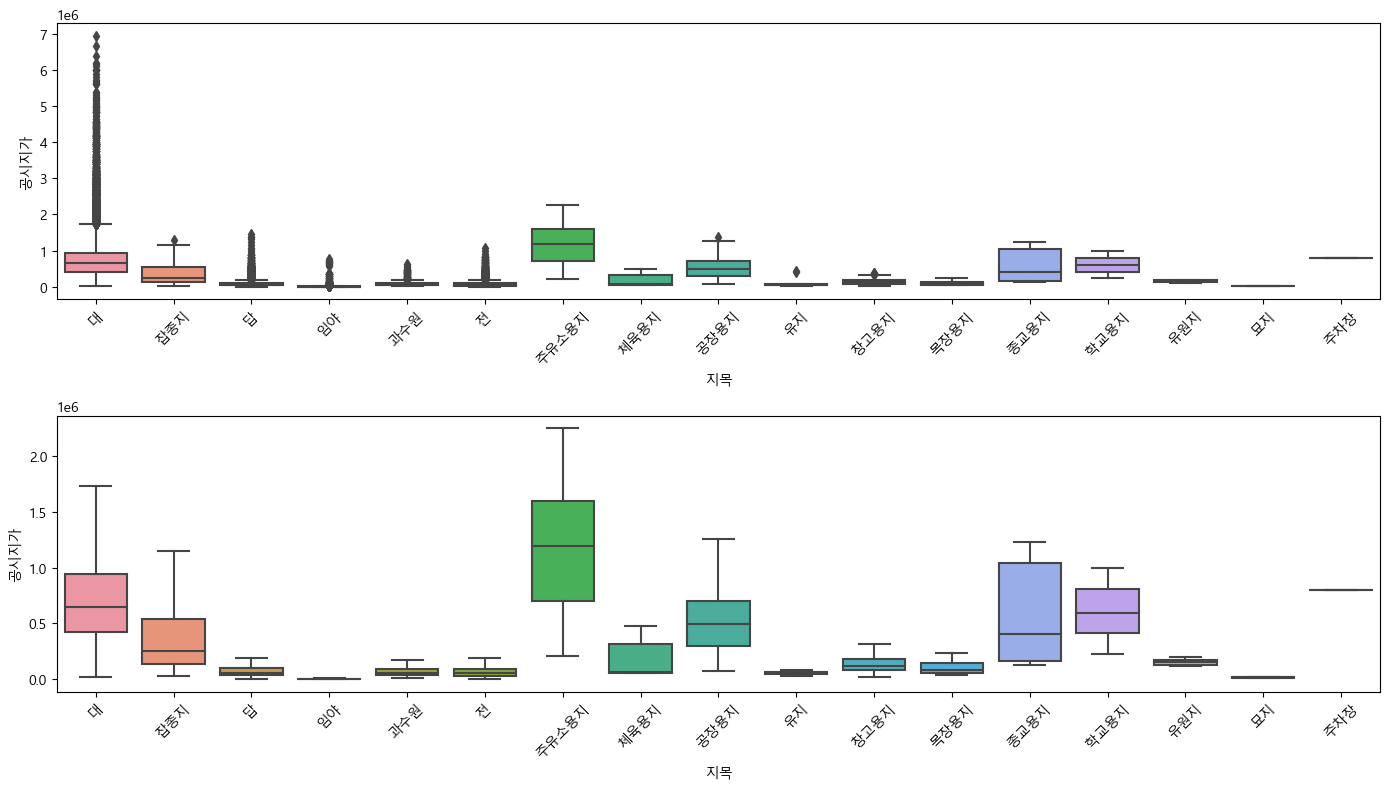

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(14,8))
sns.boxplot(data=df, x='지목', y='공시지가', ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
sns.boxplot(data=df, x='지목', y='공시지가', showfliers=False, ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

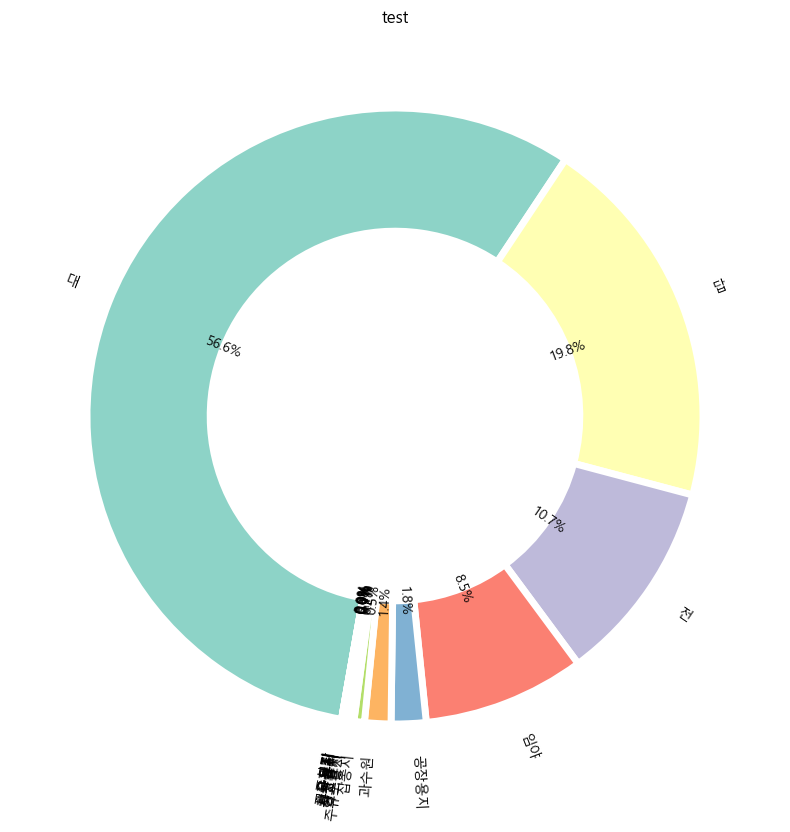

In [8]:
price_by_city = df['지목'].value_counts().sort_values(ascending=False)
ratio = price_by_city.values
labels = price_by_city.index
colors = plt.get_cmap('Set3').colors
wedgeprops={'width': 0.4, 'edgecolor': 'w', 'linewidth': 5}

plt.figure(figsize=(10, 10))
patches, labels, pct_texts = plt.pie(ratio, labels=labels, autopct='%.1f%%', startangle=260, 
        counterclock=False, colors=colors, wedgeprops=wedgeprops, rotatelabels=True)

for label, pct_text in zip(labels, pct_texts):
    pct_text.set_rotation(label.get_rotation())

plt.title('test')
plt.show()

In [9]:
jimok_value = df['지목'].value_counts()

fig = go.Figure(data=[go.Pie(labels=df['지목'].unique(), values=jimok_value, hole=0.4)])
fig.update_layout(width=700, height=600, title={
    'text': '창원시 지목별 분포',
    'y': 0.95,
    'x': 0.5,
    'xanchor': 'center',
    'yanchor': 'top',
    'font': {'size': 20}
})
# Display the figure in the notebook
fig.show()

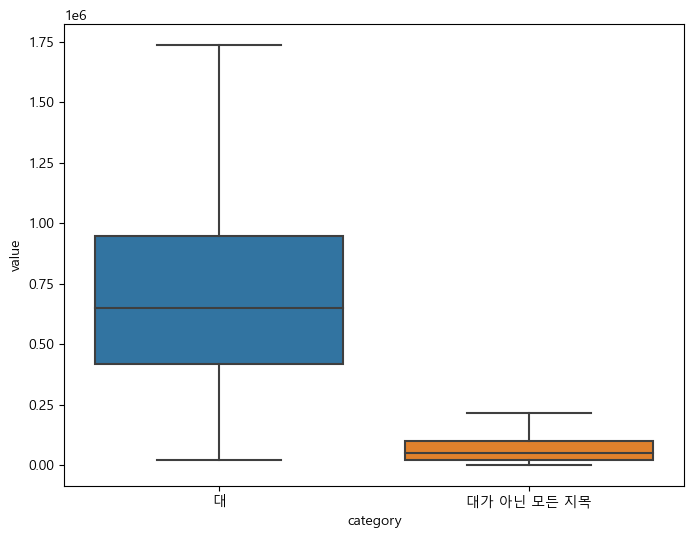

In [10]:
# 대 vS 대가 아닌 지목

dae = df[df['지목'] == '대']['공시지가']
dae_not = df[df['지목'] != '대']['공시지가']
jimok = pd.DataFrame({'category': ['대'] * len(dae) + ['대가 아닌 모든 지목'] * len(dae_not),
                      'value': pd.concat([dae, dae_not])})

plt.figure(figsize=(8, 6))
sns.boxplot(data=jimok, x='category', y='value', showfliers=False)
plt.show()


In [30]:
# # 연도별 공시지가 흐름
# fig, ax = plt.subplots(5, 2, figsize=(15, 15))
# for i in range(2012, 2022):
#     sns.histplot(df[df['연도'] == i]['공시지가'], ax=ax[(i-2012)//2, (i-2012)%2], kde=True)
#     ax[(i-2012)//2, (i-2012)%2].set_title(f'Year {i}')
#     ax[(i-2012)//2, (i-2012)%2].set_xlabel('공시지가')
#     ax[(i-2012)//2, (i-2012)%2].set_ylabel('Count')

# plt.tight_layout()
# plt.show()

In [16]:
jimok_year = df.groupby(['연도', '지목'])['공시지가'].mean().reset_index()

# 그래프 그리기
fig = px.bar(jimok_year, x='지목', y='공시지가', animation_frame='연도', range_y=[0, max(jimok_year['공시지가'])],
             color='지목', labels={'지목': '지목', '공시지가': '공시지가'},
             title='지목별 공시지가 변화')
fig.update_layout(width=1200, height=600,
    xaxis={'categoryorder': 'array', 'categoryarray': ['A', 'B', 'C']},
                  title={
    'text': '지목별 공시지가 평균의 변화',
    'y': 0.95,
    'x': 0.5,
    'xanchor': 'center',
    'yanchor': 'top',
    'font': {'size': 20}
})
fig.update_layout()
fig.show()

### 용도지역별 분석

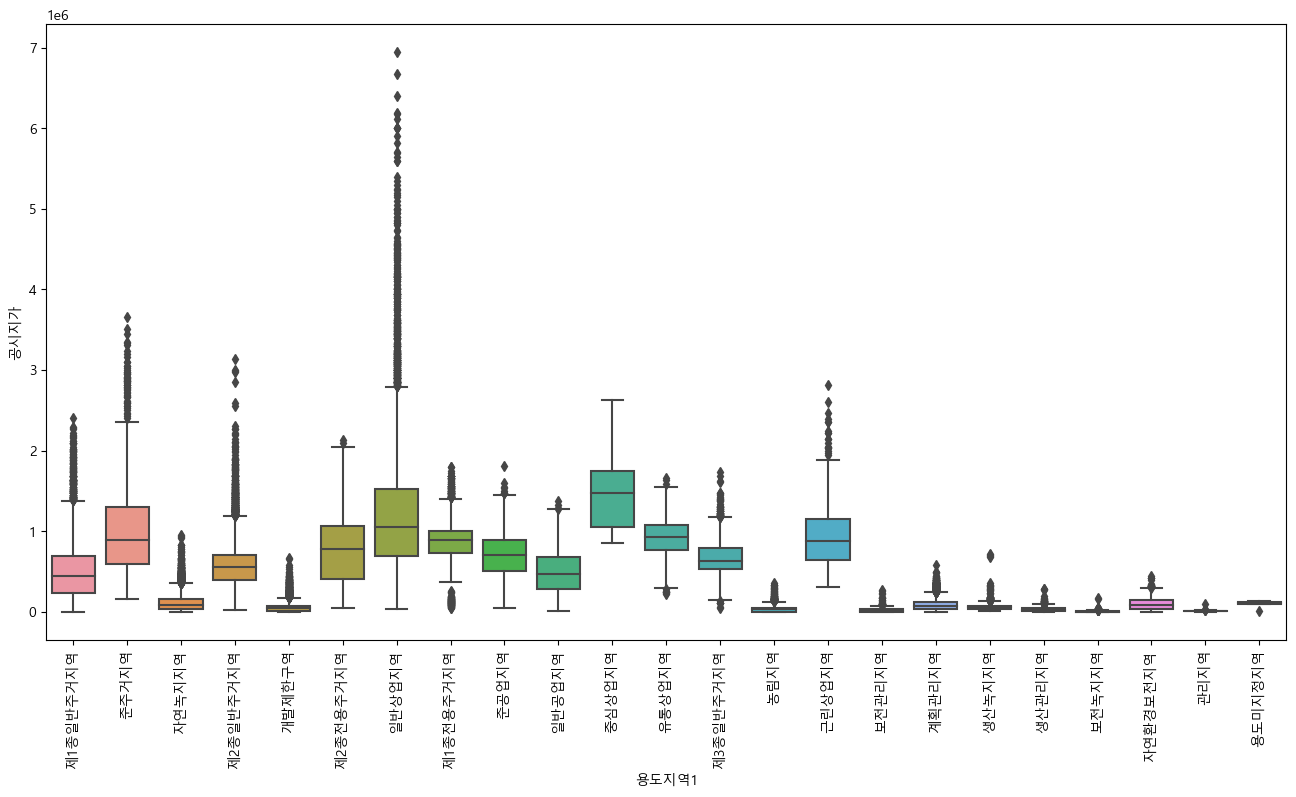

In [34]:
df['용도지역1']
plt.figure(figsize=(16,8))
sns.boxplot(data=df, x='용도지역1', y='공시지가')
plt.xticks(rotation=90)
plt.show()

In [16]:
yongdo_value = df['용도지역1'].value_counts()
fig = go.Figure(data=[go.Pie(labels=df['용도지역1'].unique(), values=yongdo_value, hole=0.4, pull=[0,0,0,0,0,0,0.2,0,0,0,0.2])])
fig.update_layout(width=800, height=650, title={
    'text': '창원시 용도지역별 분포',
    'y': 0.95,
    'x': 0.5,
    'xanchor': 'center',
    'yanchor': 'top',
    'font': {'size': 35}
})

fig.show()

In [37]:
yongdo_year = df.groupby(['연도', '용도지역1'])['공시지가'].mean().reset_index()

# 그래프 그리기
fig = px.bar(yongdo_year, x='용도지역1', y='공시지가', animation_frame='연도', range_y=[0, max(yongdo_year['공시지가'])],
             color='용도지역1', labels={'용도지역1': '용도지역', '공시지가': '공시지가'},
             title='지목별 공시지가 변화')
fig.update_layout(width=1600, height=600,
    xaxis={'categoryorder': 'array', 'categoryarray': ['A', 'B', 'C']},
                  title={
    'text': '용도지역별 공시지가 평균의 변화',
    'y': 0.95,
    'x': 0.5,
    'xanchor': 'center',
    'yanchor': 'top',
    'font': {'size': 35}
})
fig.update_layout()
fig.show()

### 지세, 형상, 도로교통에 따른 분석
> 세 가지의 조건으로 공시지가 분석 및 그래프

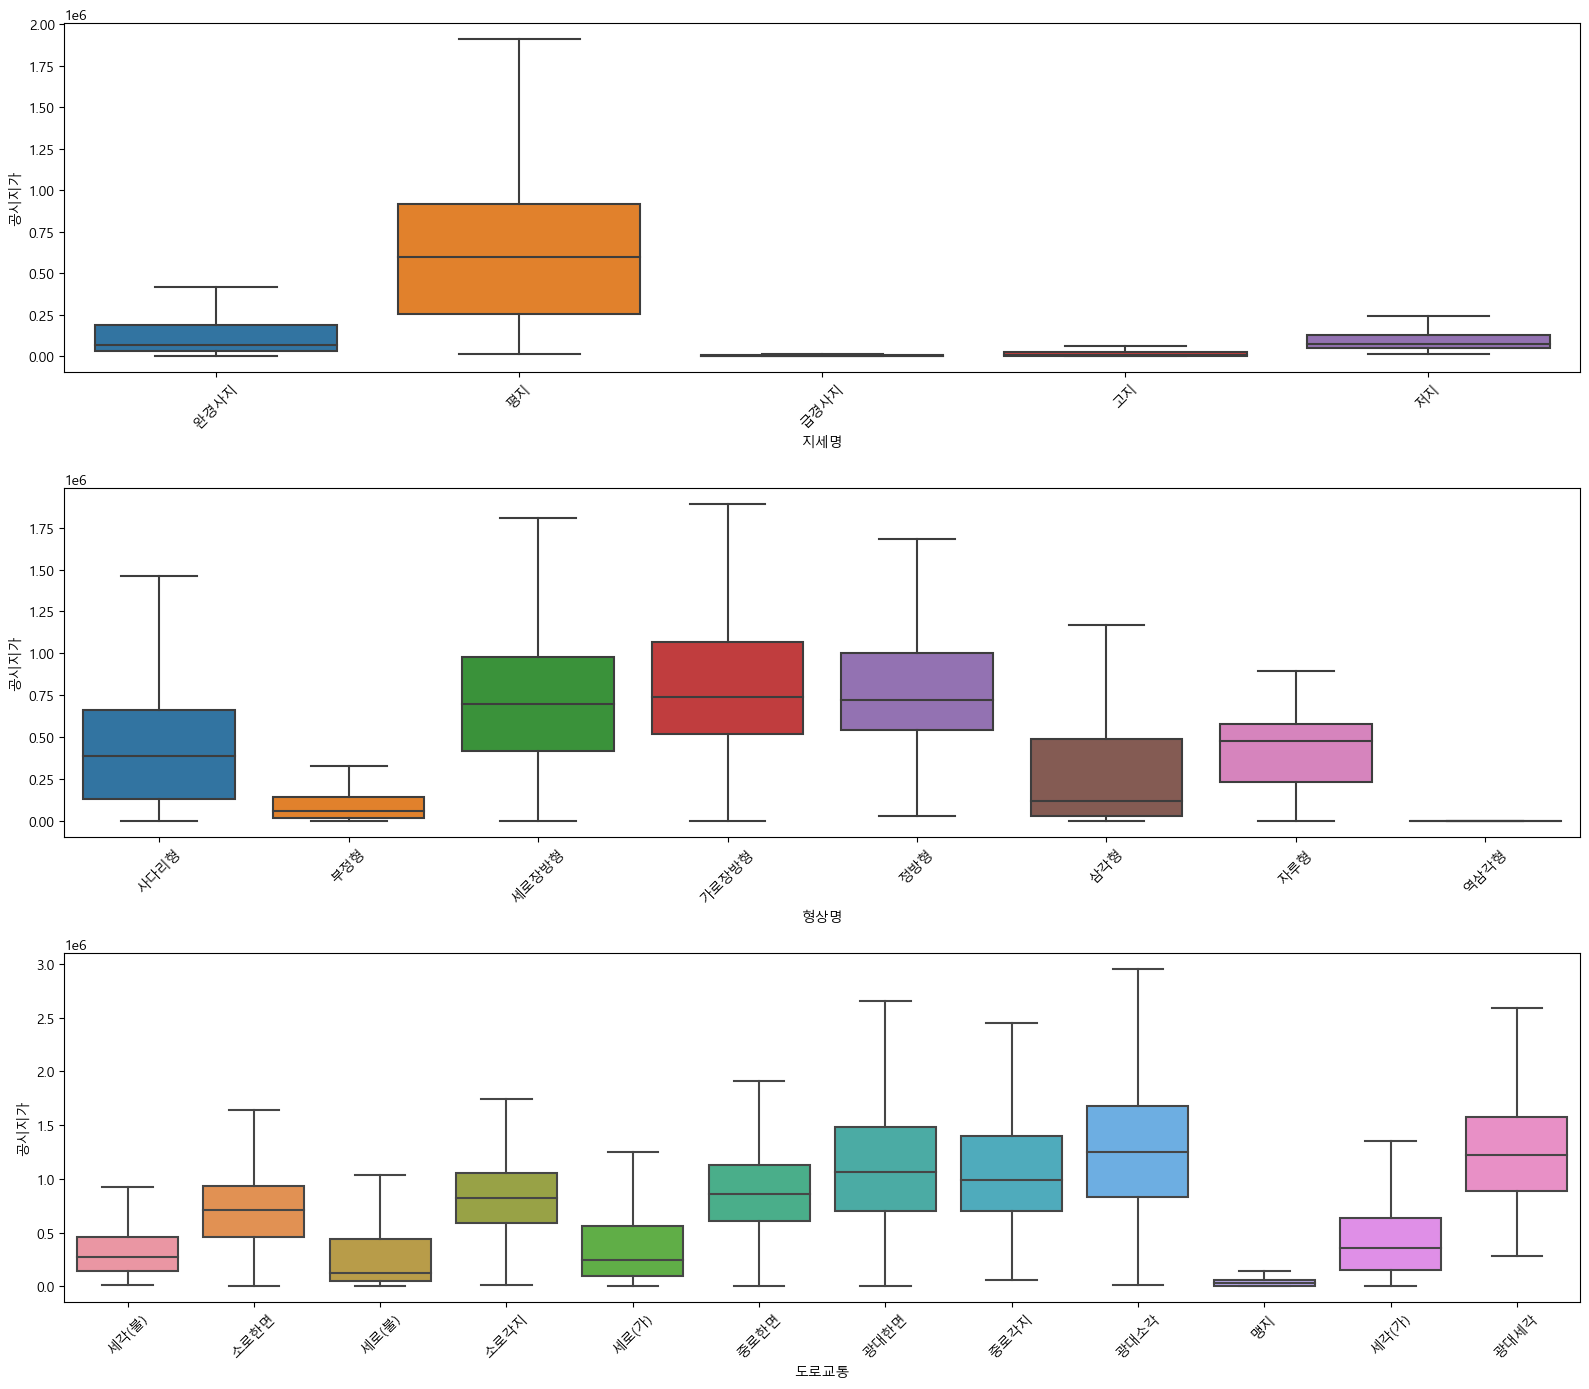

In [18]:
fig, axes = plt.subplots(3, 1, figsize=(16, 14))
lst = ['지세명', '형상명', '도로교통']
for i, ax in enumerate(axes.flatten()):
    sns.boxplot(data=df, x=lst[i], y='공시지가', showfliers=False, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

In [20]:
# 지세별 평균 공시지가
jise_year = df.groupby(['연도', '지세명'])['공시지가'].mean().reset_index()

# 그래프 그리기
fig = px.bar(jise_year, x='지세명', y='공시지가', animation_frame='연도', range_y=[0, max(jise_year['공시지가'])],
             color='지세명', labels={'지세명': '용도지역', '공시지가': '공시지가'},
             title='지세별 공시지가 변화')
fig.update_layout(width=1200, height=600,
    xaxis={'categoryorder': 'array', 'categoryarray': ['A', 'B', 'C']},
                  title={
    'text': '지세별 평균 공시지가의 변화',
    'y': 0.95,
    'x': 0.5,
    'xanchor': 'center',
    'yanchor': 'top',
    'font': {'size': 35}
})
fig.update_layout()
fig.show()

In [25]:
# 지세별 평균 공시지가
# 데이터셋 불러오기
jise = df.groupby(['연도', '지세명'])['공시지가'].mean().reset_index()

# 고유한 지세명과 색상 매핑
color_map = {'고지': 'red', '급경사지': 'blue', '완경사지': 'coral', '저지': 'green', '평지': 'turquoise'}

# 바 그래프 그리기
fig = go.Figure()
for jise_name, color in color_map.items():
    jise_data = jise[jise['지세명'] == jise_name]
    fig.add_trace(go.Bar(x=jise_data['연도'], y=jise_data['공시지가'], marker_color=color, name=jise_name))

# 선 그래프 그리기
for jise_name, color in color_map.items():
    jise_data = jise[jise['지세명'] == jise_name]
    fig.add_trace(go.Scatter(x=jise_data['연도'], y=jise_data['공시지가'], mode='lines', line=dict(color=color), name=jise_name))

# 레이아웃 설정
fig.update_layout(width=1200, height=600,
    title={
        'text': '지세별 평균 공시지가의 변화',
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 35}
    },
    xaxis_title='연도',
    yaxis_title='공시지가',
    legend_title='지세명'
)

fig.show()

In [21]:
# 지세별 평균 공시지가
shape_year = df.groupby(['연도', '형상명'])['공시지가'].mean().reset_index()

# 그래프 그리기
fig = px.bar(shape_year, x='형상명', y='공시지가', animation_frame='연도', range_y=[0, max(shape_year['공시지가'])],
             color='형상명', labels={'형상명': '용도지역', '공시지가': '공시지가'},
             title='지세별 공시지가 변화')
fig.update_layout(width=1200, height=600,
    xaxis={'categoryorder': 'array', 'categoryarray': ['A', 'B', 'C']},
                  title={
    'text': '형상명별 평균 공시지가의 변화',
    'y': 0.95,
    'x': 0.5,
    'xanchor': 'center',
    'yanchor': 'top',
    'font': {'size': 35}
})
fig.update_layout()
fig.show()

In [22]:
# 지세별 평균 공시지가
# 데이터셋 불러오기
shapes = df.groupby(['연도', '형상명'])['공시지가'].mean().reset_index()

# 고유한 지세명과 색상 매핑
color_map = {'가로방장형': 'red', '부정형': 'blue', '사다리형': 'green', '세로장방형': 'coral', '정방형': 'turquoise', '자루형':'magenta', '삼각형':'yellow', '역삼각형':'purple'}

# 바 그래프 그리기
fig = go.Figure()
for jise_name, color in color_map.items():
    jise_data = shapes[shapes['형상명'] == jise_name]
    fig.add_trace(go.Bar(x=jise_data['연도'], y=jise_data['공시지가'], marker_color=color, name=jise_name))

# 레이아웃 설정
fig.update_layout(width=1200, height=600,
    title={
        'text': '형상별 평균 공시지가의 변화',
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 35}
    },
    xaxis_title='연도',
    yaxis_title='공시지가',
    legend_title='형상명'
)

fig.show()

In [38]:
# 지세별 평균 공시지가
doro_year = df.groupby(['연도', '도로교통'])['공시지가'].mean().reset_index()

# 그래프 그리기
fig = px.bar(doro_year, x='도로교통', y='공시지가', animation_frame='연도', range_y=[0, max(doro_year['공시지가'])],
             color='도로교통', labels={'도로교통': '용도지역', '공시지가': '공시지가'},
             title='지세별 공시지가 변화')
fig.update_layout(width=1400, height=600,
    xaxis={'categoryorder': 'array', 'categoryarray': ['A', 'B', 'C']},
                  title={
    'text': '도로교통별 평균 공시지가의 변화',
    'y': 0.95,
    'x': 0.5,
    'xanchor': 'center',
    'yanchor': 'top',
    'font': {'size': 35}
})
fig.update_layout()
fig.show()

* 광로 : 40m 이상
* 대로 : 25m 이상 40m 미만 
* 중로 : 12m 이상 25m 미만
* 소로 : 8m 이상 12m 미만
* 세로 : 8m 미만

In [24]:
# 도로교통별 평균 공시지가
# 데이터셋 불러오기
shapes = df.groupby(['연도', '도로교통'])['공시지가'].mean().reset_index()

# 고유한 지세명과 색상 매핑
color_map = {'광대세각': 'red', '광대소각': 'blue', '광대한면': 'green', '소로각지': 'coral', '소로한면': 'turquoise', 
             '중로각지': 'magenta', '중로한면': 'yellow', '맹지': 'purple', '세각(가)': 'pink', '세각(불)': 'gold',
             '세로(가)': 'gray', '세로(불)': 'brown'}

# 바 그래프 그리기
fig = go.Figure()
for jise_name, color in color_map.items():
    jise_data = shapes[shapes['도로교통'] == jise_name]
    fig.add_trace(go.Bar(x=jise_data['연도'], y=jise_data['공시지가'], marker_color=color, name=jise_name))

# 레이아웃 설정
fig.update_layout(width=1200, height=600,
    title={
        'text': '도로교통별 평균 공시지가의 변화',
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 35}
    },
    xaxis_title='연도',
    yaxis_title='공시지가',
    legend_title='도로교통'
)

fig.show()

### 이상치 발견 및 제거

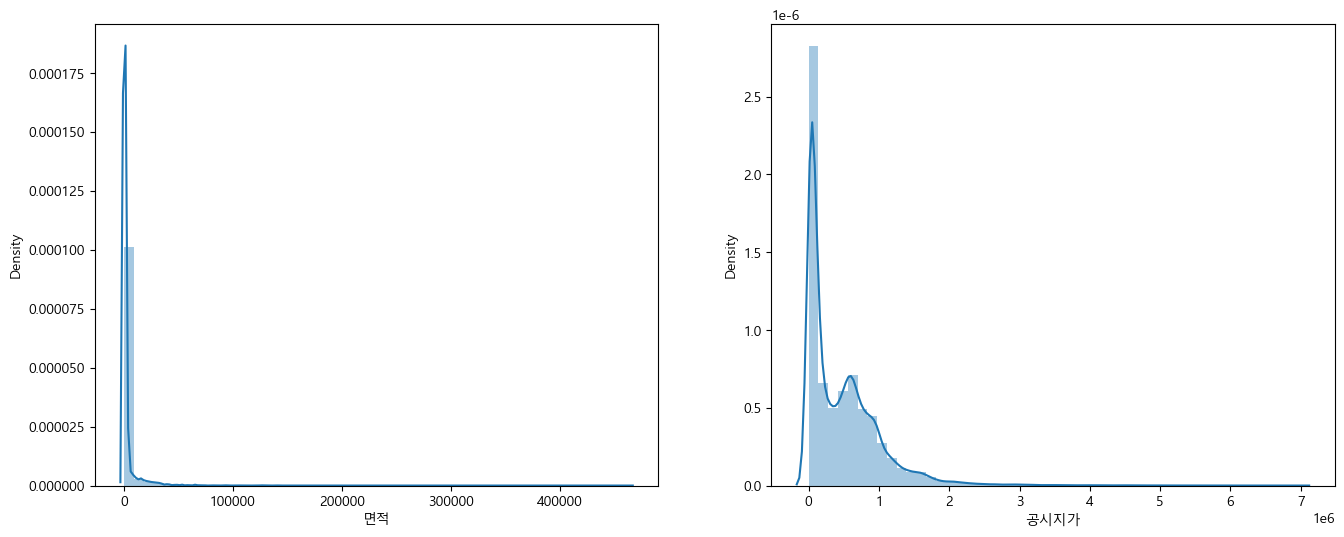

In [56]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,6))
sns.distplot(df['면적'], ax=ax1)
sns.distplot(df['공시지가'], ax=ax2)

plt.show()

In [27]:
df[df['면적'] >= 200000].sort_values(by='공시지가', ascending=False)

,시도명,시군구명,소재지,지목,면적,용도지역1,이용상황,주위환경,지세명,형상명,도로교통,공시지가,연도,가격
4950329,경상남도,창원성산구,성주동 28,공장용지,249896.7,일반공업지역,공업용,산업단지,평지,사다리형,광대한면,578000,2021-01-01,1.444403e+11
3932773,경상남도,창원성산구,성주동 28,공장용지,249896.7,일반공업지역,공업용,산업단지,평지,사다리형,광대소각,560000,2019-01-01,1.399422e+11
4432734,경상남도,창원성산구,성주동 28,공장용지,249896.7,일반공업지역,공업용,산업단지,평지,사다리형,광대소각,560000,2020-01-01,1.399422e+11
3432835,경상남도,창원성산구,성주동 28,공장용지,249896.7,일반공업지역,공업용,산업단지,평지,사다리형,광대한면,560000,2018-01-01,1.399422e+11
2887216,경상남도,창원성산구,성주동 28,공장용지,249896.7,일반공업지역,공업용,산업단지,평지,사다리형,광대한면,543000,2017-01-01,1.356939e+11
2433128,경상남도,창원성산구,성주동,공장용지,250540.9,일반공업지역,공업용,산업단지,평지,사다리형,광대한면,505000,2016-01-01,1.265232e+11
1933194,경상남도,창원성산구,성주동 28,공장용지,250540.9,일반공업지역,공업용,산업단지,평지,사다리형,광대한면,500000,2015-01-01,1.252704e+11
1433209,경상남도,창원성산구,성주동 28,공장용지,250540.9,일반공업지역,공업용,산업단지,평지,사다리형,광대한면,470000,2014-01-01,1.177542e+11
933228,경상남도,창원성산구,성주동 28,공장용지,250540.9,일반공업지역,공업용,산업단지,평지,사다리형,광대한면,430000,2013-01-01,1.077326e+11
433221,경상남도,창원성산구,성주동 28,공장용지,250540.9,일반공업지역,공업용,산업단지,평지,사다리형,광대한면,400000,2012-01-01,1.002164e+11


In [80]:
df = df.drop(df[df['면적'] >= 1500000].index)

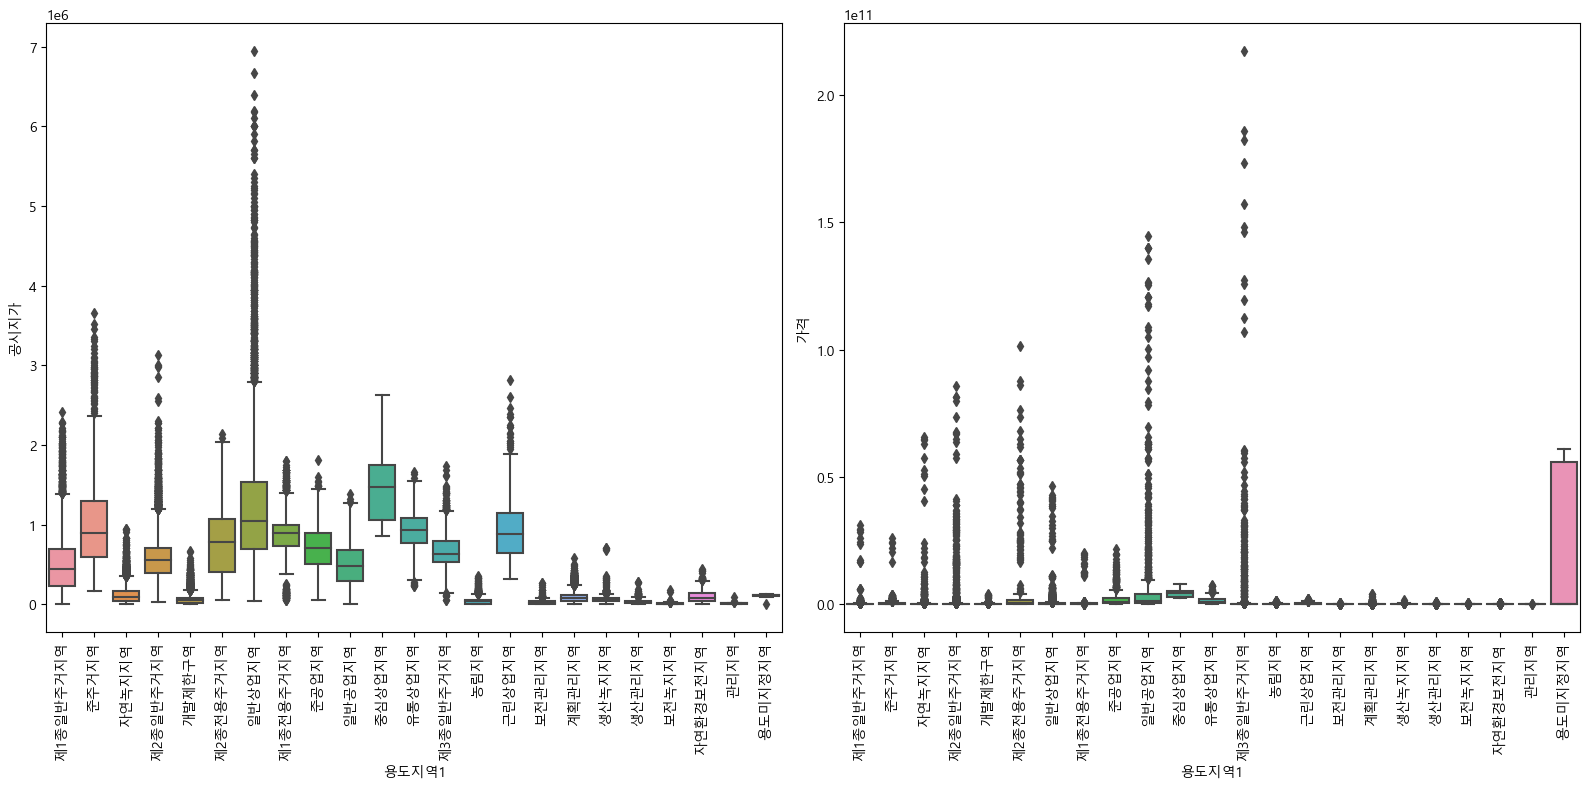

In [11]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,8))
sns.boxplot(x=df['용도지역1'], y=df['공시지가'], ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
sns.boxplot(x=df['용도지역1'], y=df['가격'], ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()

In [12]:
df[df['용도지역1'] == '용도미지정지역']

,시도명,시군구명,소재지,지목,면적,용도지역1,이용상황,주위환경,지세명,형상명,도로교통,공시지가,연도,가격
435535,경상남도,창원마산합포구,진전면 율티리 336-2,잡종지,585.0,용도미지정지역,주거나지,미성숙 주택지대,평지,사다리형,세로(가),95000,2012,5.557500e+07
935542,경상남도,창원마산합포구,진전면 율티리 336-2,잡종지,585.0,용도미지정지역,주거나지,미성숙 주택지대,평지,사다리형,세로(가),99000,2013,5.791500e+07
1435524,경상남도,창원마산합포구,진전면 율티리 336-2,잡종지,585.0,용도미지정지역,주거나지,미성숙 주택지대,평지,사다리형,세로(가),104000,2014,6.084000e+07
1932351,경상남도,창원의창구,북면 감계리 산97-1,임야,8610.0,용도미지정지역,자연림,순수 산림지대,급경사지,사다리형,맹지,4500,2015,3.874500e+07
1935500,경상남도,창원마산합포구,진전면 율티리 336-2,잡종지,585.0,용도미지정지역,주거나지,미성숙 주택지대,평지,사다리형,세로(가),110000,2015,6.435000e+07
2435438,경상남도,창원마산합포구,율티리,잡종지,585.0,용도미지정지역,주거나지,미성숙 주택지대,평지,사다리형,세로(가),116000,2016,6.786000e+07
3937541,경상남도,창원진해구,수도동 297,잡종지,463826.3,용도미지정지역,매립,미개발지대,평지,세로장방형,광대한면,120000,2019,5.565916e+10
4437468,경상남도,창원진해구,수도동 297,잡종지,463826.3,용도미지정지역,매립,미개발지대,평지,세로장방형,광대한면,120000,2020,5.565916e+10
4955372,경상남도,창원진해구,수도동 297,잡종지,463826.3,용도미지정지역,공업나지,산업단지,평지,세로장방형,광대한면,131500,2021,6.099316e+10


In [7]:
df = df.drop(df[df['용도지역1'] == '용도미지정지역'].index)

### 모델 학습을 위한 데이터 가공
> 특성 선택 및 원핫인코딩

In [9]:
original = original.drop(['이용상황', '주위환경','시군구명'], axis=1)
df = df.drop(['이용상황', '주위환경','시군구명', '소재지'], axis=1)
original

,시도명,지목,면적,용도지역1,지세명,형상명,도로교통,공시지가,연도
0,서울특별시,공원,1021.5,자연녹지지역,급경사지,부정형,세로(불),346000,2012
1,서울특별시,대,416.2,제1종일반주거지역,완경사지,사다리형,세로(가),2300000,2012
2,서울특별시,대,811.3,제1종일반주거지역,급경사지,부정형,세로(가),2150000,2012
3,서울특별시,대,552.1,제1종일반주거지역,평지,사다리형,소로각지,3280000,2012
4,서울특별시,대,538.8,제1종일반주거지역,완경사지,세로장방형,세로(가),2880000,2012
...,...,...,...,...,...,...,...,...,...
5019995,제주특별자치도,전,8473.0,계획관리지역,평지,사다리형,맹지,17500,2021
5019996,제주특별자치도,전,12365.0,계획관리지역,평지,사다리형,소로한면,54000,2021
5019997,제주특별자치도,과수원,2912.0,계획관리지역,완경사지,부정형,세로(가),45000,2021
5019998,제주특별자치도,과수원,1537.0,계획관리지역,완경사지,부정형,중로한면,79500,2021


In [10]:
X_original = original.drop(['공시지가'], axis=1)
X_df = df.drop(['공시지가'], axis=1)
y_original = original['공시지가']
y_df = df['공시지가']

In [12]:
# 라벨 인코딩
le = LabelEncoder()
lst = df[['시도명','지목', '용도지역1', '지세명', '형상명', '도로교통']].columns

for i in lst:
    df[i] = le.fit_transform(df[i])
df
# 수치형 열 표준화
mmscaler = MinMaxScaler()
mmlst = ['면적', '연도']

for i in mmlst:
    df[i] = mmscaler.fit_transform(df[[i]])
df
# original_numeric = mmscaler.fit_transform(original_encoded)
df_numeric = mmscaler.fit_transform(df)

In [60]:
# One-Hot Encoding 적용
original_encoded = pd.get_dummies(X_original)
df_encoded = pd.get_dummies(X_df)

# 수치형 열 표준화
mmscaler = MinMaxScaler()
original_numeric = mmscaler.fit_transform(original_encoded)
df_numeric = mmscaler.fit_transform(df_encoded)

ValueError: y should be a 1d array, got an array of shape (5020000, 8) instead.

In [95]:
df.drop('가격', axis=1, inplace=True)

In [32]:
# PCA 수행
pca = PCA(n_components=3)
# original_pca = pca.fit_transform(original_numeric)
df_pca = pca.fit_transform(df_numeric)

In [33]:
# print(original_pca.shape)
print(df_pca.shape)

(72734, 3)


In [34]:
# 데이터 나누기
X_train_val, X_test, y_train_val, y_test = train_test_split(df_pca, y_df, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=1)


## <b> 3. 모델 학습 및 검증 </b>

> <b> (작업 내용 작성 예) </b> 일반적으로 '공시지가'가 매해 증가한다는 점을 고려하여 선형회귀를 모델로 선정함.

In [35]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

추세 amrima? 합쳐서

In [46]:
# 모델 객체를 생성합니다.
dtr = DecisionTreeRegressor(max_depth=5, random_state=42)

# 모델을 학습시킵니다.
dtr.fit(X_train, y_train)

# 모델을 사용하여 예측합니다.
y_pred = dtr.predict(X_val)

# 예측 결과를 평가합니다.
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mse)
mape_val = mape(y_val, y_pred)

print('Validation Set:')
print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)
print('MAPE:', mape_val)

Validation Set:
MAE: 215148.06025401506
MSE: 150062916186.64816
RMSE: 387379.550553005
MAPE: 1.77388502823877


In [48]:
# test set으로 예측
y_test_pred = dtr.predict(X_test)

mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
mape_test = mape(y_test, y_test_pred)

print('Test Set:')
print('MAE:', mae_test)
print('MSE:', mse_test)
print('RMSE:', rmse_test)
print('MAPE:', mape_test)

Test Set:
MAE: 211571.09996136787
MSE: 143789196371.45404
RMSE: 379195.4593233601
MAPE: 1.785984139918147


In [44]:
rf = RandomForestRegressor(n_estimators=100, max_depth=5, min_samples_split=4, min_samples_leaf=1, random_state=1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mse)
mape_val = mape(y_val, y_pred)

print('Validation Set:')
print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)
print('MAPE:', mape_val)

Validation Set:
MAE: 209694.2608609732
MSE: 140208113804.85953
RMSE: 374443.7391716672
MAPE: 1.729916200646954


In [45]:
y_test_pred = rf.predict(X_test)

mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
mape_test = mape(y_test, y_test_pred)

print('Test Set:')
print('MAE:', mae_test)
print('MSE:', mse_test)
print('RMSE:', rmse_test)
print('MAPE:', mape_test)

Test Set:
MAE: 207656.59294024896
MSE: 134611310618.91885
RMSE: 366894.1408893291
MAPE: 1.7401405670912664


In [23]:
param_grid = {'n_estimators': [100, 300, 500],
              'max_depth': [3, 5, 7],
              'min_samples_split': [2, 4, 6],
              'min_samples_leaf': [1, 2, 4]}

rf = RandomForestRegressor(random_state=1)
gs = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)
gs.fit(X_train, y_train)
best_model = gs.best_estimator_
y_pred = best_model.predict(X_val)

# 모델 평가
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mse)
print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)

# 잔차 그래프 그리기
residuals = y_val - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

KeyboardInterrupt: 

> <b> (작업 내용 작성 예) </b> 2012-2021년 공시지가를 훈련 데이터로 사용하여 선형회귀 모델을 학습함.

In [22]:
# 코드 및 결과

> <b> (작업 내용 작성 예) </b> 훈련 데이터와 테스트 데이터에 대한 정확도는 각각 96%, 83%로 확인됨.

평가지표 - mae 보다는 mean absolute percentage error

In [23]:
# 코드 및 결과

## <b> 4. 결과 분석 및 고찰 </b>

> * 전체 프로젝트 과정을 간략하게 기술
> * 예측 결과를 분석하고 추가 및 보완해야 할 점을 기술

예) 땅을 넓히는 것? 길을 내는 것? 어느 쪽이 더 공시지가가 올라가는지  
더 다듬을 수 있다면, 작업을 더 개선할 수 있을만한 사안